# Genetic Hyperparameter Optimization (LSTM)

## Environment Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
import math
from operator import itemgetter
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from keras.layers import Dense, Flatten, SpatialDropout1D, Activation, Add, BatchNormalization, LSTM
from keras.models import Input, Model
from keras.engine.topology import Layer
from keras.constraints import unit_norm
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.models import Sequential

from matplotlib import pyplot as plt
import pylab as pl
from keras.callbacks import EarlyStopping


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FBL3N.XLSX to FBL3N.XLSX
Saving ZF0025.XLSX to ZF0025.XLSX


In [ ]:
import io
BOVA11 = pd.read_csv(io.BytesIO(uploaded['BOVA_INPUT.csv']))
BOVA11_C = BOVA11['LOG_RETURN']
BOVA11_C.fillna(0)

# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[10,5])
# train, test = get_search_dataset()
# ax.plot(test[:])

#fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])
#ax.plot(acf(series_treino,nlags=2000))
#ax.set_title("Autocorrelation for factor A")
#ax.set_ylabel("ACF")
#ax.set_xlabel("LAG")

0      0.023319
1      0.038266
2      0.001137
3      0.005666
4     -0.000226
         ...   
366    0.005543
367   -0.016282
368    0.017690
369   -0.023768
370    0.017906
Name: LOG_RETURN, Length: 371, dtype: float64

In [ ]:
def get_search_dataset():
  train = BOVA11_C.iloc[:int(0.7*len(BOVA11_C))]
  test =  BOVA11_C.iloc[int(0.7*len(BOVA11_C)):]
  return train,test
  

## Evolutionary Algorithm

In [ ]:
"""## Evolutionary Algorithm"""

###Gera indivíduos após operadores


#Gera indivíduos após operadores
def genotype(units, dropout, norm, lags, num_layers, rmse, num_param):
  ind = {
      'units': units, #número de unidades [50- 100]
      'dropout': dropout, # porcentagem dropout (0 a 1)
      'norm': norm, # normalização (0 - sim, 1 - não)
      'lags': lags, # quantidade de lags [1- 50]
      'num_layers': num_layers, # número de camadas [1 - 5]
      'rmse': rmse, #RMSE de teste do modelo
      'num_param':num_param   #número de parâmetros do modelo

  }
  return ind

"""###Gera primeiros indivíduos"""

#Gera indivíduos
def random_genotype(): 
  return genotype(
    random.randint(1, 16), #número de unidades [50- 100]
    random.uniform(0, 0.5),  #porcentagem dropout (0 a 0.5)
    random.randint(0, 1),   # normalização (0 - sim, 1 - não)
    random.randint(1, 50),   # quantidade de lags [1- 50]
    random.randint(1, 5), # número de camadas [1 - 5]
    [], #RMSE de teste do modelo
    []  #número de parâmetros do modelo
  )
  

"""###Gera população"""

#Gera uma população de tamanho n
def initial_population(n):
  pop = []
  for i in range(n): 
    pop.append(random_genotype())
  return pop

"""###Avalia indivíduos"""

#Função de avaliação
def slideWindow(train, test, n_lags):
    """
    train1: dados de treinamento
    n_lags: quantidade de preditores
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(n_lags, len(train)):
        X_train.append(train[i-n_lags:i])
        y_train.append(train[i])
    for i in range(n_lags, len(test)):
        X_test.append(test[i-n_lags:i])
        y_test.append(test[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    return X_train, y_train, X_test, y_test



def criaModel_LSTM(X_train, y_train, X_test, y_test, individual):
  model = Sequential()
  call = [EarlyStopping(monitor='loss', mode='min', patience=15, verbose=1),]
  for i in range(individual['num_layers']):
    if i != individual['num_layers']:
      model.add(LSTM(units=individual['units'], activation='relu', input_shape=(X_train.shape[1],1), return_sequences=True))
    else:
      model.add(LSTM(units=individual['units'], activation='relu', input_shape=(X_train.shape[1],1), return_sequences=False))
    model.add(SpatialDropout1D(round(individual['dropout'],1)))
    if individual['norm'] == 0:
      model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(1))
  #adam = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(loss='mse', optimizer='Adam')
  history = model.fit(X_train, y_train, epochs = 100, verbose=0, batch_size=32, callbacks = call)
            
  return model, history

def evaluation(individual):
  print("Entrou na evaluation")
  series,_ = get_search_dataset()
  X = series
  windows_size=.5
  train_size=.7
  w = int(len(series) * windows_size)
  d = int(.2 * w)
  X_train = []
  y_train = []
  X_test = []
  y_test = []
  i=0

  try:
    results = []
    
    while i < w:
      train_index = (series[i:i+int(w*train_size)].index.values.astype(int))
      test_index = (series[i+int(w*train_size):w+i].index.values.astype(int))
      train = X[train_index].values
      test = X[test_index].values
      X_train, y_train, X_test, y_test = slideWindow(train, test, individual['lags'])
      model, history = criaModel_CNN(X_train, y_train, X_test, y_test, individual)
      results.append(np.sqrt(history.history['val_loss'][-1]))
      i = i+d
      
    rmse = np.nanmean(results)
    num_param = model.count_params()
      
    return num_param, rmse
  
  except Exception as ex:
    print("EXCEPTION!", str(ex), str(individual))
    rmse = 2
    num_param = 20000
    return num_param, rmse

"""###Seleção de pais"""

def tournament(population, objective):
  n = len(population)-1
  
  r1 = random.randint(0,n) if n > 2 else 0
  r2 = random.randint(0,n) if n > 2 else 1
  ix = r1 if population[r1][objective] < population[r2][objective] else r2
  return population[ix]
  

def selection1(population):
  pai1 = tournament(population, 'rmse')
  pai2 = tournament(population, 'rmse')
    
  finalista = tournament([pai1, pai2], 'num_param')
    
  return finalista

"""###Cruzamento"""

#Cruzamento
def crossover(pais):
  import random

  if pais[0]['rmse'] < pais[1]['rmse'] :
    best = pais[0] 
    worst = pais[1]
  else:
    best = pais[1]
    worst = pais[0]
  
  dropout = float(.7*best['dropout'] + .3*worst['dropout'])
  
  rnd = random.uniform(0,1)
  norm = best['norm'] if rnd < .7 else worst['norm']
  
  rnd = random.uniform(0,1)
  units = best['units'] if rnd < .7 else worst['units']
  
  rnd = random.uniform(0,1)
  num_layers = best['num_layers'] if rnd < .7 else worst['num_layers']
    
  rnd = random.uniform(0,1)
  lags = best['lags'] if rnd < .7 else worst['lags']
    
  rmse = []
  num_param = []
    
  filho = genotype(units, dropout, norm, lags, num_layers, rmse, num_param)
  
  return filho

"""###Mutação"""

#Mutação | p é a probabilidade de mutação
def mutation(individual):
  individual['dropout'] = min(.5, max(0,individual['dropout'] + np.random.normal(0,.1)))
  individual['units'] = min(100, max(50,int(individual['units'] + np.random.normal(0,.1))))
  individual['num_layers'] = min(5, max(1,int(individual['num_layers'] + np.random.normal(0,.1))))
  individual['norm'] = random.randint(0,1)
  individual['lags'] = min(50, max(1,int(individual['lags'] + np.random.normal(0,.1))))
  
  return individual

"""###Elitismo"""

#Elitismo
def elitism(population, new_population):
  #Pega melhor indivíduo da população corrente
  population = sorted(population, key=itemgetter('rmse')) 
  best = population[0]
  
  #Ordena a nova população e insere o melhor1 no lugar do pior
  new_population = sorted(new_population, key=itemgetter('rmse')) 
  new_population[-1] = best
  
  #Ordena novamente e pega o melhor
  new_population = sorted(new_population, key=itemgetter('rmse')) 
  
  return new_population

"""###Algoritmo principal"""

fig = pl.gcf()
fig.set_size_inches(15, 5)

#Algoritmo genético | ngen: número de gerações | npop: tamanho da população
def genetico(ngen, npop, pcruz, pmut):
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])
  new_populacao = []
  #Gerar população inicial
  populacao = initial_population(npop)
  melhor_rmse = []
  media_rmse = []
  melhor_len_lags = []
  media_len_lags = []

  #Avalia a populacao
  res = list(map(evaluation, populacao))
  for i in range(len(res)):
    populacao[i]['num_param'],populacao[i]['rmse'] = res[i]
    
  print("fim da 1 avaliação")
  #Gerações
  for i in range(ngen):
    print(i)
    #Iteração para gerar a nova população
    for j in range(int(npop/2)):
      #Selecao de pais
      pais = []
      pais.append(selection1(populacao))
      pais.append(selection1(populacao))

      #Cruzamento com probabilidade pcruz
      rnd = random.uniform(0,1)
      filho1 = crossover(pais) if pcruz > rnd else pais[0]
      rnd = random.uniform(0,1)
      filho2 = crossover(pais) if pcruz > rnd else pais[1]
      
      #Mutação com probabilidade pmut
      rnd = random.uniform(0,1)
      filho11 = mutation(filho1) if pmut > rnd else filho1
      rnd = random.uniform(0,1)
      filho22 = mutation(filho2) if pmut > rnd else filho2
      
      #Insere filhos na nova população
      new_populacao.append(filho11)
      new_populacao.append(filho22)
      
      #-------------------------------------------------------------------
    
    #Avalia a new_populacao
    res = list(map(evaluation, new_populacao))
    for i in range(len(res)):
      new_populacao[i]['num_param'],new_populacao[i]['rmse'] = res[i]

    print('fim da 2 avaliação')
    
    #Elitismo: populacao agora é a new_populacao + elitismo
    populacao = elitism(populacao, new_populacao)
    _best = populacao[0]
    
    melhor_rmse.append(_best['rmse'])
    media_rmse.append(sum([k['rmse'] for k in populacao])/len(populacao))
    melhor_len_lags.append(_best['num_param'])
    media_len_lags.append(sum([k['num_param'] for k in populacao])/len(populacao))

    new_populacao = []
    
  pl.subplot(121)
  h1, = pl.plot(melhor_rmse, c='blue', label='Best RMSE')
  h2, = pl.plot(media_rmse, c='cyan', label='Mean RMSE')
  pl.title("RMSE")
  pl.legend([h1, h2],['Best','Mean'])
    
  pl.subplot(122)
  h3, = pl.plot(melhor_len_lags, c='red', label='Best Número de parâmetros')
  h4, = pl.plot(media_len_lags, c='orange', label='Mean Número de parâmetros')
  pl.title("Número de parâmetros")
  pl.legend([h3, h4],['Best','Mean'])
    
  display.clear_output(wait=True)
  display.display(pl.gcf())
    
  #---------------------------------------------------------------------
  #Retorna melhor indivíduo
  melhorT = sorted(populacao, key=lambda item: item['rmse'])[0]

  return melhorT

<Figure size 1080x360 with 0 Axes>

#Executa GA

Entrou na evaluation
EXCEPTION! name 'criaModel_CNN' is not defined {'units': 11, 'dropout': 0.35733562363521293, 'norm': 1, 'lags': 26, 'num_layers': 5, 'rmse': [], 'num_param': []}
fim da 1 avaliação
0
fim da 2 avaliação


IndexError: ignored

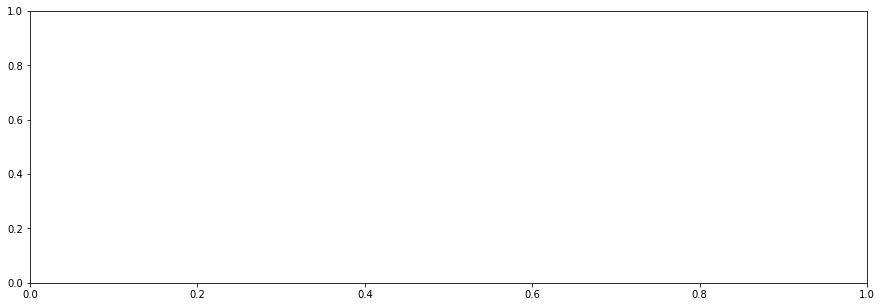

In [ ]:
#Testa algoritmo genético
#Entradas: ngen: numero de gerações | npop: tamanho da população | pcruz: probabilidade de cruzamento | pmut: probabilidade de mutação
import time
start = time. time()
melhor = genetico(1, 1, .5, .3) #Usar número par para quantidade de indivíduos
end = time. time()
print(end - start)
print(melhor)



#Previsão com o modelos escolhido pelo GA

In [ ]:
def slideWindow_val(series, n_lags):
    X_test = []
    y_test = []
    for i in range(n_lags, len(series)):
        X_test.append(series[i-n_lags:i])
        y_test.append(series[i])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    X_test = X_test.astype ('float32')
    return X_test, y_test

def predictModel(series, model,n_previsoes, n_lags, scaler):
    X_test, y_test = slideWindow_val(series, n_lags)
    yhat = np.zeros((y_test.shape[0],n_previsoes))
    rmse = []
    mape = []
    for i in range(len(X_test)):
        X = X_test[i,:,0].reshape((1, X_test.shape[1], X_test.shape[2]))
        for j in range(n_previsoes):
            yhat[i,j] = model.predict(X, verbose=0)
            X = np.insert(X,n_lags,yhat[i,j],axis=1) 
            X = np.delete(X,0,axis=1)
    yhat = scaler.inverse_transform(yhat)
    y_test = scaler.inverse_transform(y_test)
    for i in range(n_previsoes):
        rmse.append(np.sqrt(mean_squared_error(yhat[0:(yhat.shape[0])-i,i],y_test[i:])))
        mape.append(mean_absolute_error(yhat[0:(yhat.shape[0])-i,i],y_test[i:]))
    return rmse, mape, yhat, y_test
  
def plots(rmse, yhat, y_test, mape):
    #Plota o y_test e o yhat
    plt.figure(1,figsize=(15, 5))
    plt.plot(y_test[:],color='green')
    plt.plot(yhat[:,0],color='red')
    plt.xlabel('Tempo')
    plt.ylabel('Eto')
    plt.title('Previsão Eto')
    plt.legend(['Eto real','Eto predito'])
    
    #Plota o rmse ao longo das previsões para os 10 dias
    plt.figure(2,figsize=(8, 5))
    plt.plot(rmse, color='Blue')
    #plt.plot(mape, color='Orange')
    plt.xlabel('Dias')
    plt.title('RMSE e MAPE ao longo dos 10 dias de previsão para cada treinamento')
    plt.legend(['RMSE','MAPE'])

In [ ]:
melhor = {    
      'units': 16, #número de unidades [50- 100],
      'dropout': 0.3, # porcentagem dropout (0 a 1)
      'norm': 0, # normalização (0 - sim, 1 - não)
      'lags': 4, # quantidade de lags [1- 50]
      'num_layers': 4, # número de camadas [1 - 5]
      'rmse': 0.076, #RMSE de teste do modelo
      'num_param':25507   #número de parâmetros do modelo
}

In [ ]:
series_treino, series_teste = get_search_dataset()
series_teste = pd.concat([series_treino[series_treino.shape[0] - melhor['lags']:], series_teste])
series_treino = series_treino.values.reshape(-1, 1)
series_teste = series_teste.values.reshape(-1, 1)
scaler = MinMaxScaler()
series_treino = scaler.fit_transform(series_treino)
series_teste = scaler.fit_transform(series_teste)
X_train, y_train, X_test, y_test = slideWindow(series_treino, series_teste, melhor['lags'])
model,_ = criaModel_LSTM(X_train, y_train, X_test, y_test, melhor)

Epoch 00097: early stopping


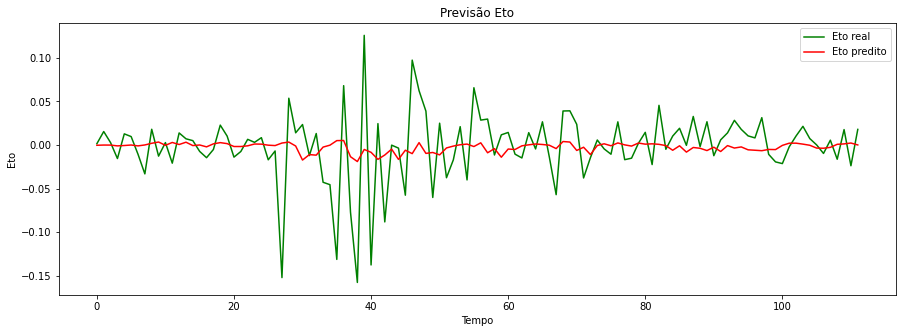

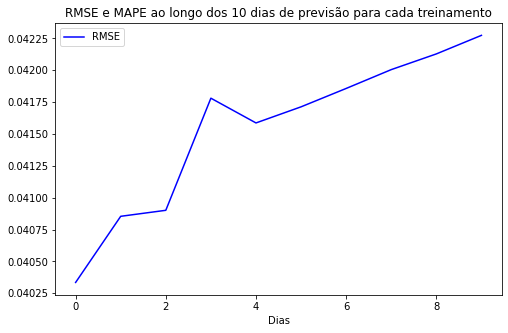

In [ ]:
rmse, mape, yhat, y_test = predictModel(series_teste, model, 10, melhor['lags'], scaler)
plots(rmse, yhat, y_test, mape)

In [ ]:
print(rmse)

[0.0403344377328188, 0.04085363105165817, 0.040900760114801385, 0.041780869380802624, 0.041586641096018694, 0.04171311087697352, 0.04185739933603149, 0.042005192861745325, 0.04212845505245187, 0.042274176432312204]


##Teste com 30 execuções

In [ ]:
media = []
series_treino, series_teste = get_search_dataset()
series_teste = pd.concat([series_treino[series_treino.shape[0] - melhor['lags']:], series_teste])
series_treino = series_treino.values.reshape(-1, 1)
series_teste = series_teste.values.reshape(-1, 1)
scaler = MinMaxScaler()
series_treino = scaler.fit_transform(series_treino)
series_teste = scaler.fit_transform(series_teste)
X_train, y_train, X_test, y_test = slideWindow(series_treino, series_teste, melhor['lags'])
for i in range(15):
  model, history = criaModel_LSTM(X_train, y_train, X_test, y_test, melhor)
  rmse, mape, yhat, y_test = predictModel(series_teste, model, 10, melhor['lags'],scaler)
  media.append(rmse)
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [ ]:
mm = np.array(media)
m2 = np.mean(mm, axis=0)
m2

array([0.04241675, 0.04236088, 0.04281596, 0.04302639, 0.04324117,
       0.04338391, 0.04354595, 0.04377985, 0.04392599, 0.04404216])

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,9],dpi = 1000)
sns.set(style="ticks",palette="pastel")
df = pd.DataFrame(mm)
g1 = sns.boxplot(data=df)
box = g1.get_position()
#g1.set_position([box.x0, box.y0, box.width * 0.85, box.height]) 
#g1.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1)
ax.set_title("Previsão média em 10 dias se utilizando a LSTM", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.set_ylabel("RMSE", fontsize=18)
ax.set_xlabel("Dias", fontsize=18)
plt.savefig("img21.pdf")
files.download("img21.pdf") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df1 = df.T
frames = [df1.iloc[:,0], df1.iloc[:,1], df1.iloc[:,2], df1.iloc[:,3], df1.iloc[:,4], df1.iloc[:,5],
         df1.iloc[:,6], df1.iloc[:,7], df1.iloc[:,8], df1.iloc[:,9], df1.iloc[:,10], df1.iloc[:,11],
         df1.iloc[:,12], df1.iloc[:,13], df1.iloc[:,14], df1.iloc[:,15], df1.iloc[:,16], df1.iloc[:,17],
         df1.iloc[:,18], df1.iloc[:,19], df1.iloc[:,20], df1.iloc[:,21], df1.iloc[:,22], df1.iloc[:,23],
         df1.iloc[:,24], df1.iloc[:,25], df1.iloc[:,26], df1.iloc[:,27], df1.iloc[:,28], df1.iloc[:,29]]


result = pd.concat(frames)
r = pd.DataFrame(result) 
r.insert(1, "Model", True) 
for i in range(300):
  r['Model'].iloc[i] = 'LSTM'

r

NameError: ignored

In [ ]:
import pandas as pd
from google.colab import files

LSTM = r.to_csv('LSTM',index=True)
files.download('LSTM')